References:   
https://www.kaggle.com/lapidshay/bilstm-for-text-classification    
https://github.com/YangLinyi/SVM-CNN-RNN-HAN-Popular-NLP-Models    

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

from copy import deepcopy
import gc

import nltk
from nltk.tokenize import TweetTokenizer  # Twitter-aware tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

import torch
import torch.nn as nn

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
from sklearn import metrics 

**Pre-defined Evaluation Functions**

In [2]:
def Get_Accuracy(y_true, y_pred): #Accuracy 准确率：分类器正确分类的样本数与总样本数之比 
    accuracy = metrics.accuracy_score(y_true,y_pred)  
    return accuracy

def Get_Precision_score(y_true, y_pred): #Precision：精准率 正确被预测的正样本(TP)占所有被预测为正样本(TP+FP)的比例. 
    precision = metrics.precision_score(y_true,y_pred)  
    return precision

def Get_Recall(y_true, y_pred): #Recall 召回率 正确被预测的正样本(TP)占所有真正 正样本(TP+FN)的比例.  
    Recall = metrics.recall_score(y_true,y_pred)  
    return Recall 
 
def Get_f1_score(y_true, y_pred): #F1-score: 精确率(precision)和召回率(Recall)的调和平均数  
    f1_score = metrics.f1_score(y_true,y_pred)  
    return f1_score

**Read Data**

In [3]:
train_path = ''
dev_path = ''
test_path = ''

train_df = pd.read_csv(train_path, sep='\t')
dev_df = pd.read_csv(dev_path, sep='\t')
test_df = pd.read_csv(test_path, sep='\t')

In [4]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
dev_df = dev_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

**Print dataframe to check the shape**  
Back part of this jupyter used some specific column names only for this specific dataset. So check your dataset to make sure use it in the correct shape.

In [5]:
train_df

,Sentiment,Text
0,Positive,"Considering it was made on a low budget, THE D..."
1,Negative,"Peter Sellers plays Dick Scratcher (ha,ha), a ..."
2,Positive,Great fun. I went with 8 friends to a sneak pr...
3,Negative,This was a watershed event in my movie watchin...
4,Negative,In case half of this film's footage looks stra...
...,...,...
1702,Positive,Nobody said movies had to be realistic did the...
1703,Positive,I tracked the trip two years ago on the intern...
1704,Positive,"I liked this a lot. In fact, if I see it again..."
1705,Positive,Kureishi hasn't exactly been blessed with movi...


In [6]:
dev_df

,Sentiment,Text
0,Positive,This movie is a lot of fun. The actors really ...
1,Positive,MULHOLLAND DRIVE made me the definitive fan of...
2,Positive,I only saw this recently but had been aware of...
3,Negative,***SPOILERS*** ***SPOILERS*** When I saw a pre...
4,Positive,There's something wonderful about the fact tha...
...,...,...
240,Negative,"As a Native film professor, I can honestly say..."
241,Negative,"Dumb is as dumb does, in this thoroughly unint..."
242,Positive,I am normally skeptical about watching films o...
243,Negative,"I am not a big fan of horror films, and have o..."


In [7]:
test_df

,Sentiment,Text
0,Positive,I rate this 10 out of 10. Why?<br /><br />* It...
1,Positive,Dead To Rights is about a Police Officer named...
2,Positive,I saw this jolly little film at age 10/11 in 1...
3,Negative,Felt mine was while watching this...but it see...
4,Positive,And that's how the greatest comedy of TV start...
...,...,...
483,Negative,I have two good things to say about this film:...
484,Negative,I can say without a shadow of a doubt that Goi...
485,Negative,"""Demons III: The Ogre"" is not related pre-sequ..."
486,Negative,I own this movie. I bought it for $3.99 at a f...


**Cleansing label to numeric**

In [8]:
def clean_target(target_col):
    new_labels = []
    for each in target_col:
        if each == 'Negative':
            new_labels.append(0)
        elif each == 'Positive':
            new_labels.append(1)
    return new_labels
        
# train_df['Sentiment'] = clean_target(train_df['Sentiment'])
# dev_df['Sentiment'] = clean_target(dev_df['Sentiment']) 
# test_df['Sentiment'] = clean_target(test_df['Sentiment'])      

**Text Pre-processing functions and tokenizer**

In [9]:
def _normalize_tweet(text):
    """Returns a normalized versions of text."""

    # change hyperlinks to '<url>' tokens
    output = re.sub(r'http[s]{0,1}://t.co/[a-zA-Z0-9]+\b', '<url>', text)
    
    # separate all '#' signs from following word with one whitespace
    output = re.sub(r'#(\w+)', r'# \1', output)

    return output

def _tokenize(tokenizer, string):
    """Tokenizes a sentence, but leave hastags (#) and users (@)"""
    
    tokenized = tokenizer.tokenize(string)
    return tokenized

def _numbers_to_number_tokens(tokenized_string, num_token='<number>'):
    """Returns the tokenized string (list) with numbers replaced by a numbet token."""
    
    # create a list of (word, POS-tags) tuples
    pos_tagged = nltk.pos_tag(tokenized_string)
    
    # find indices of number POS tags
    num_indices = [idx for idx in range(len(pos_tagged)) if pos_tagged[idx][1] == 'CD']
    
    # replace numbers by token
    for idx in num_indices:
        tokenized_string[idx] = num_token
        
    return tokenized_string

def preprocess_text(tokenizer, string):
    """Executes all text cleaning functions."""
    
    return _numbers_to_number_tokens(_tokenize(tokenizer, _normalize_tweet(string)))

In [10]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False) 

**Glove embedding**

In [11]:
# embeddings_dict = {}
# with open("GloVe/glove.6B.300d.txt", 'r') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vector = np.asarray(values[1:], "float32")
#         embeddings_dict[word] = vector

**Split train and test**   
if you use only one data source

In [12]:
#Seperate data into feature and results
# X, y = text, labels

#Split data in train and test sets.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

**Define feature and target, transform with Glove**

In [13]:
X_train = train_df['Text'].to_list()
X_dev = dev_df['Text'].to_list()
X_test = test_df['Text'].to_list()
y_dev = np.array(clean_target(dev_df['Sentiment'].to_list()))
y_train = np.array(clean_target(train_df['Sentiment'].to_list()))
y_test = np.array(clean_target(test_df['Sentiment'].to_list()))

In [14]:
tokenized_X_train = [preprocess_text(tokenizer,each) for each in X_train]
tokenized_X_dev = [preprocess_text(tokenizer,each) for each in X_dev]
tokenized_X_test = [preprocess_text(tokenizer,each) for each in X_test]

In [15]:
# load a pre-trained model, which was trained on twitter
model_glove_twitter = api.load("glove-twitter-50")

In [16]:
# create a random vector, to represent <UNK> token (unseen word)
random_vec_for_unk = np.random.uniform(-1, 1, size=model_glove_twitter.vector_size).astype('float32')
random_vec_for_unk = random_vec_for_unk.reshape(1,model_glove_twitter.vector_size)
# add the random vector to model
model_glove_twitter.add(['<UNK>'], random_vec_for_unk, replace=True)
# compute noramlized vectors, and replace originals
model_glove_twitter.init_sims(replace=True)

In [17]:
def embedding_preprocess(embedding_model, use_norm, seq_len, tokenized_text):
    """Returns an embedding representation of input tokenized text, by executing text embedding functions."""
    
    # get matrix of tweet's words' embedding vectors (tweet length, embedding_dimension)
    text_vectors = _text_to_vectors(embedding_model, use_norm, tokenized_text)
    
    output = _trim_and_pad_vectors(text_vectors, embedding_model.vector_size, seq_len)
    
    return output

In [18]:
def _text_to_vectors(embedding_model, use_norm, tokenized_text):
    """Returns tweet's words' embedding vector.s"""

    vectors = [_get_word_vec(embedding_model, use_norm, word) for word in tokenized_text]
    vectors = np.array(vectors)
    
    return vectors

def _get_word_vec(embedding_model, use_norm, word):
    """
    Returns a normalized embedding vector of input word.
    
    Takes care of special cases.
    <url> tokens are already taken care of in normalization.
    """

    if word[0] == '@':
        return embedding_model.word_vec('<user>', use_norm=use_norm)
        
    elif word == '#':
        return embedding_model.word_vec('<hashtag>', use_norm=use_norm)

    elif word in embedding_model.vocab:
        return embedding_model.word_vec(word, use_norm=use_norm)

    else:
        return embedding_model.word_vec('<UNK>', use_norm=use_norm)

def _trim_and_pad_vectors(text_vectors, embedding_dimension, seq_len):
    """Returns a padded matrix of text embedding vectors with dimensions (seq_len, embedding dimensions)."""

    # instantiate 0's matrix
    output = np.zeros((seq_len, embedding_dimension))

    # trim long tweets to be seq_len long
    trimmed_vectors = text_vectors[:seq_len]

    # determine index of end of padding and beginning of tweet embedding
    end_of_padding_index = seq_len - trimmed_vectors.shape[0]

    # pad if needed, by replacing last rows with the tweet's words' embedding vectors
    output[end_of_padding_index:] = trimmed_vectors

    return output

In [19]:
sequence_max_length = 300

In [20]:
embeded_X_train = [embedding_preprocess(embedding_model=model_glove_twitter, use_norm=True, 
                    seq_len=sequence_max_length, tokenized_text=each) for each in tokenized_X_train]
embeded_X_dev = [embedding_preprocess(embedding_model=model_glove_twitter, use_norm=True, 
                    seq_len=sequence_max_length, tokenized_text=each) for each in tokenized_X_dev]
embeded_X_test = [embedding_preprocess(embedding_model=model_glove_twitter, use_norm=True, 
                    seq_len=sequence_max_length, tokenized_text=each) for each in tokenized_X_test]

In [21]:
X_train = np.array(embeded_X_train)
X_dev = np.array(embeded_X_dev)
X_test = np.array(embeded_X_test)

In [22]:
def embeddings(X, sequence_max_length):
    """Returns one embedding representation of all features - main sequence, static embedded featues, and single values.""" 
    
    # instantiate output matrix
    output = np.zeros((len(X), 300, 50))
    
    # instantiate output matrix
    
    for idx, row in enumerate(X):
        
        row_embedding = row.reshape(300, 67)
        output[idx, :, :] = row_embedding
    
    print(output.shape)
    return output

**Bi-directional LSTM**

In [23]:
class BiLSTM(nn.Module):
    """A pyTorch Bi-Directional LSTM RNN implementation"""

    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes, batch_size, dropout, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(p=dropout)

        self.lstm = nn.LSTM(
            input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout, bidirectional=True)
        
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

        self.device = device
        
        # instantiate lists for evaluating and plotting
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        
        # an attribute to hold model's best weights (used for evaluating)
        self.best_weights = deepcopy(self.state_dict())
    
    def save(self, PATH):
        torch.save(self.best_weights, PATH)

    def _init_hidden(self, current_batch_size):
        """Sets initial hidden and cell states (for LSTM)."""

        h0 = torch.zeros(self.num_layers * 2, current_batch_size, self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, current_batch_size, self.hidden_dim).to(self.device)
        return h0, c0

    def forward(self, x):
        """Forward step."""

        # Forward propagate LSTM
        h, c = self._init_hidden(current_batch_size=x.size(0))
        out, _ = self.lstm(x, (h, c))

        # dropout
        out = self.dropout(out)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out
    
    def predict(self, x: torch.tensor):
        """Return a tensor of predictions of tensor x."""

        class_predictions = self(x).data
        _, predicted = torch.max(class_predictions, dim=1)
        return predicted

    def _train_evaluate(self, X_train, y_train, X_val, y_val, criterion):
        """Evaluates model during training time, and returns train_loss, train_acc, val_loss, val_acc."""

        # set model to evaluation mode
        self.eval()

        # calculate accuracy and loss of train set and append to lists
        epoch_train_acc = (self.predict(X_train) == y_train).sum().item() / y_train.shape[0]
        epoch_train_loss = criterion(self(X_train), y_train).item()
        self.train_acc.append(epoch_train_acc)
        self.train_loss.append(epoch_train_loss)

        # calculate accuracy and loss of validation set, and append to lists
        if X_val is not None and y_val is not None:
            epoch_val_acc = (self.predict(X_val) == y_val).sum().item() / y_val.shape[0]
            epoch_val_loss = criterion(self(X_val), y_val).item()
            self.val_acc.append(epoch_val_acc)
            self.val_loss.append(epoch_val_loss)

            # return all loss and accuracy values
            return epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc

        # return train set loss and accuracy values, if there is no validation set
        return epoch_train_loss, epoch_train_acc, None, None
    
    @staticmethod
    def _print_progress(epoch, train_loss, train_acc, val_loss, val_acc, improved, verbose=False):
        """Prints the training progress."""

        output = f'Epoch {str(epoch + 1).zfill(3)}:'
        output += f'\n\t Training   Loss: {str(train_loss)[:5]} | Accuracy: {str(train_acc)[:5]}.'

        if val_loss is not None and val_acc is not None:
            output += f'\n\t Validation Loss: {str(val_loss)[:5]} | Accuracy: {str(val_acc)[:5]}.'

        if improved:
            output += f' Improvement!'

        if verbose:
            print(output)

    def fit(self, X_train, y_train, X_val, y_val, epoch_num, criterion, optimizer, verbose=False):
        """Trains the model."""

        # a variable to determine whether to update best weights (and report progress)
        best_acc = 0.0
        
        print(X_train.shape)
        
        # split dataset to batches
        X_train_tensor_batches = torch.split(X_train, self.batch_size)
        y_train_tensor_batches = torch.split(y_train, self.batch_size)

        for epoch in range(epoch_num):

            # set model to train mode
            self.train()

            for i, (X_batch, y_batch) in enumerate(zip(X_train_tensor_batches, y_train_tensor_batches)):

                # Forward pass
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # calculate accuracy and loss of train and validation set (if validation set is None, values are None)
            train_loss, train_acc, val_loss, val_acc = self._train_evaluate(X_train, y_train, X_val, y_val, criterion)

            # a boolean to determine the correct accuracy to consider for progress (Validation ot Training)
            if X_val is not None and y_val is not None:
                accuracy = val_acc
            else:
                accuracy = train_acc

            # if accuracy outperforms previous best accuracy, print and update best accuracy and model's best weights
            if accuracy > best_acc:
                self._print_progress(epoch, train_loss, train_acc, val_loss, val_acc, improved=True, verbose=verbose)
                best_acc = accuracy
                self.best_weights = deepcopy(self.state_dict())

            # else, print
            else:
                self._print_progress(epoch, train_loss, train_acc, val_loss, val_acc, improved=False, verbose=verbose)

        gc.collect()

In [24]:
def plot_graphs(model):
    plt.figure(figsize=(6, 12))

    plt.subplot(311)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1, len(model.train_acc)+1), model.train_acc, label="Train")
    plt.plot(range(1, len(model.val_acc)+1), model.val_acc, label="Validation")

    plt.xticks(np.arange(0, len(model.train_acc)+1, 5))
    plt.legend()

    plt.subplot(312)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1, len(model.train_loss)+1), model.train_loss, label="Train")
    plt.plot(range(1, len(model.val_loss)+1), model.val_loss, label="Validation")

    plt.xticks(np.arange(0, len(model.train_acc)+1, 5))
    plt.legend()

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

**Train a Bi-LSTM model**

In [25]:
# determines which device to mount the model to
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [26]:
# convert above LSTM arrays to tensors to be used in BiLSTM Neural Network
X_train_val = torch.from_numpy(X_train).float().to(device)
X_held_out_set = torch.from_numpy(X_dev).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train_val = torch.from_numpy(y_train).long().to(device)
y_held_out_set = torch.from_numpy(y_dev).long().to(device)
y_test = torch.from_numpy(y_test).long()

hyprer-parameters

In [27]:
# network hyprer-parameters
embedding_dim = 50
hidden_size = 50
num_layers = 2
num_classes = 2
batch_size = 32
dropout = 0.3

In [28]:
# learning hyprer-parameters
num_epochs = 20
learning_rate = 0.001
weight_decay = 0.0005

In [29]:
# instantiate Model, Loss and Optimizer
bilstm = BiLSTM(embedding_dim, hidden_size, num_layers, num_classes, batch_size, dropout, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [30]:
# train the model
bilstm.fit(
    X_train=X_train_val, y_train=y_train_val, X_val=X_held_out_set, y_val=y_held_out_set,
    epoch_num=num_epochs, criterion=criterion, optimizer=optimizer, verbose=True)

torch.Size([1707, 300, 50])
Epoch 001:
	 Training   Loss: 0.693 | Accuracy: 0.498.
	 Validation Loss: 0.693 | Accuracy: 0.497. Improvement!
Epoch 002:
	 Training   Loss: 0.692 | Accuracy: 0.498.
	 Validation Loss: 0.692 | Accuracy: 0.497.
Epoch 003:
	 Training   Loss: 0.691 | Accuracy: 0.504.
	 Validation Loss: 0.691 | Accuracy: 0.493.
Epoch 004:
	 Training   Loss: 0.690 | Accuracy: 0.500.
	 Validation Loss: 0.689 | Accuracy: 0.497.
Epoch 005:
	 Training   Loss: 0.649 | Accuracy: 0.611.
	 Validation Loss: 0.630 | Accuracy: 0.669. Improvement!
Epoch 006:
	 Training   Loss: 0.689 | Accuracy: 0.499.
	 Validation Loss: 0.688 | Accuracy: 0.497.
Epoch 007:
	 Training   Loss: 0.683 | Accuracy: 0.609.
	 Validation Loss: 0.682 | Accuracy: 0.6.
Epoch 008:
	 Training   Loss: 0.687 | Accuracy: 0.514.
	 Validation Loss: 0.686 | Accuracy: 0.497.
Epoch 009:
	 Training   Loss: 0.644 | Accuracy: 0.590.
	 Validation Loss: 0.641 | Accuracy: 0.608.
Epoch 010:
	 Training   Loss: 0.594 | Accuracy: 0.661.
	 

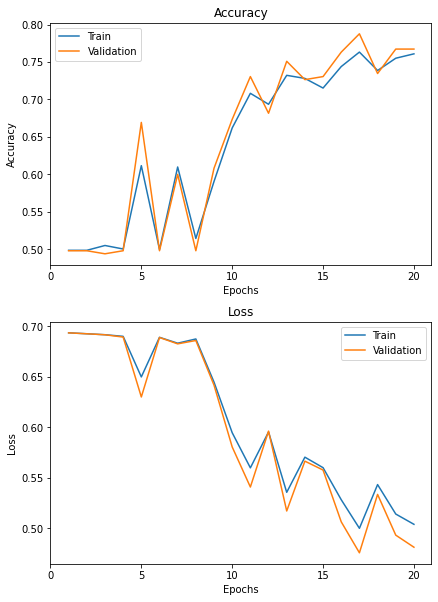

In [31]:
plot_graphs(bilstm)

In [32]:
# del(bilstm)

**Evaluation**

In [33]:
predicted = bilstm.predict(X_test).to('cpu').tolist()

In [34]:
# f = open("result.txt","a")
accuracy = Get_Accuracy(y_test, predicted)
# f.write("SVM Accuracy_Score = %f",accuracy)
precision = Get_Precision_score(y_test, predicted)
# f.write("SVM Precision = %f",precision)
recall = Get_Recall(y_test, predicted)
# f.write("SVM Recall = %f",recall)
f1_score = Get_f1_score(y_test, predicted)
print("Bidirectional LSTM evaluation Result: Accuracy {:.2%}  ".format(accuracy),\
      "Precision {:.2%}  ".format(precision),\
      "Recall {:.2%}  ".format(recall),\
      "F1-Score {:.2%}  ".format(f1_score))
# f.write("SVM F1-Score  = %f",f1_score)
# f.close()

Bidirectional LSTM evaluation Result: Accuracy 73.57%   Precision 77.10%   Recall 67.35%   F1-Score 71.90%  
